# Understanding the Australian housing bubble

## Author: Hoang Van Phan

It is well-known that residential house prices in Australia, especially in the capital cities such as Sydney and Melbourne, has become extremely unaffordable. For example, [this](https://www.abc.net.au/news/2020-11-06/property-bubble-burst-coronavirus-pandemic-house-prices/12852854) ABC news story is just one of many reports on the housing bubble, and the fear of its burst. The Australian government also recognizes this problem, as shown in the [housing affordability report](https://www.aph.gov.au/about_parliament/parliamentary_departments/parliamentary_library/pubs/briefingbook45p/housingaffordability) submitted to the Australian Parliament. The report showed that the median house price-to-income ratio had increased from approximately 3 in 1980 to over 6 by 2010.

To explain this ever increasing house price, people often point to immigration. Indeed, Australia has been an immigration-friendly country, and in 2019 there were 7.5 million immigrants living in Australia. However, one against this explaination is that the house prices still increased despite a total ban on immigration because of the COVID-19 pandemic, according to a Sydney Morning Herald [report](https://www.smh.com.au/business/the-economy/why-are-australian-home-prices-rising-again-and-can-it-last-20210126-p56wte.html). Another reason could be that the number of houses being built does not keep up with the demand, as suggested by The Economist's [special report](https://www.economist.com/special-report/2020/01/16/housing-is-at-the-root-of-many-of-the-rich-worlds-problems).

In this notebook, I attempt to analyze the various factors contributing to the house price in Australia, and to determine the magnitude of each factor. This kind of analysis not only helps understand the reasons behind the housing bubble, but also identifies possible policy changes that could alleviate the affordability crisis.

## Method

I will use linear regression to model the house price index based on the following factors:
1. Inflation: house price should at least increase with inflation.
2. Population: this contributes to the demand of more houses. If no new houses are built, then the house price should in crease with the Australian population.
3. Federal reserve interest rate: this contributes to the demand of houses. If the interest rate set by the Reserve Bank of Australia (RBA) is low, both the mortgage interest rate and treasury bond yield would also be low. These two factors make investment in houses more attractive (more people will be willing to take a larger mortgage, and people will want to divest from bonds to houses, respecitvely).
4. Stock market return: if the stock market is not performing well, then investors should be more interested in investment properties.
5. Number of newly built houses: this contribute to the supply of houses. If more houses are built without any change in demand, the house price should decrease.
6. Australian dollar's strength: a cheap Australian dollar could make investment properties in Australia more attractive to overseas investors, thus driving up demand.

## Data import

#### Load packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import yfinance as yf

import statsmodels.api as sm

#### House price data

Here I use the annual nominal house price index.

In [2]:
# Residential property price index data from OECD
RPPI = pd.read_csv("OECD_AUS_house_price.csv")
RPPI.head()

,COU,Country,IND,Indicator,TIME,Time,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUS,Australia,HPI_YDH,Price to income ratio,1970,1970,IDX,Index,0,Units,NaN,NaN,57.438309,NaN,NaN
1,AUS,Australia,HPI_YDH,Price to income ratio,1970-Q1,Q1-1970,IDX,Index,0,Units,NaN,NaN,56.338912,NaN,NaN
2,AUS,Australia,HPI_YDH,Price to income ratio,1970-Q2,Q2-1970,IDX,Index,0,Units,NaN,NaN,56.555524,NaN,NaN
3,AUS,Australia,HPI_YDH,Price to income ratio,1970-Q3,Q3-1970,IDX,Index,0,Units,NaN,NaN,59.616270,NaN,NaN
4,AUS,Australia,HPI_YDH,Price to income ratio,1970-Q4,Q4-1970,IDX,Index,0,Units,NaN,NaN,57.242530,NaN,NaN


In [3]:
# Only use annual nominal house price
RPPI = RPPI.loc[(RPPI["IND"]=="HPI") & (~RPPI["Time"].str.contains("Q")),["Time","Value"]].set_index("Time")

# Change dtype of the index
RPPI.index = RPPI.index.astype("int")

#### Inflation

Here I use the total consummer price index (CPI) as a measure of inflation. I think that the house price should be more correlated to the CPI itself, rather than the inflation rate.

In [4]:
# Use data from OECD
inflation = pd.read_csv("OECD_AUS_CPI.csv")
inflation.head()

,LOCATION,Country,SUBJECT,Subject,MEASURE,Measure,FREQUENCY,Frequency,TIME,Time,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUS,Australia,CP040000,"CPI: 04 - Housing, water, electricity, gas and...",IXOB,Index,A,Annual,1973,1973,IDX,Index,0,Units,2015_100,2015=100,9.728057,NaN,NaN
1,AUS,Australia,CP040000,"CPI: 04 - Housing, water, electricity, gas and...",IXOB,Index,A,Annual,1974,1974,IDX,Index,0,Units,2015_100,2015=100,11.209370,NaN,NaN
2,AUS,Australia,CP040000,"CPI: 04 - Housing, water, electricity, gas and...",IXOB,Index,A,Annual,1975,1975,IDX,Index,0,Units,2015_100,2015=100,13.353970,NaN,NaN
3,AUS,Australia,CP040000,"CPI: 04 - Housing, water, electricity, gas and...",IXOB,Index,A,Annual,1976,1976,IDX,Index,0,Units,2015_100,2015=100,15.498560,NaN,NaN
4,AUS,Australia,CP040000,"CPI: 04 - Housing, water, electricity, gas and...",IXOB,Index,A,Annual,1977,1977,IDX,Index,0,Units,2015_100,2015=100,17.267300,NaN,NaN


In [5]:
# Use total, non-seasonally adjusted CPI
inflation = inflation.loc[(inflation["Measure"]=="Index") & (inflation["Subject"].str.contains("01-12")),["Time","Value"]].set_index("Time")

#### Population

In [6]:
# Use data from the Australian Bureau of Statistics
population = pd.read_excel("ABS_AUS_population.xls", sheet_name="Data1")
population.head()

,Unnamed: 0,Births ; Australia ;,Deaths ; Australia ;,Natural Increase ; Australia ;,Interstate Arrivals ; Australia ;,Interstate Departures ; Australia ;,Overseas Arrivals ; Australia ;,Overseas Departures ; Australia ;,Net Permanent and Long Term Movement ; Australia ;,Migration Adjustment ; Australia ;,Net Overseas Migration ; Australia ;,Estimated Resident Population (ERP) ; Australia ;,ERP Change Over Previous Year ; Australia ;,Percentage ERP Change Over Previous Year ; Australia ;
0,Unit,000,000,000,000,000,000,000,000,000,000,000,000,Percent
1,Series Type,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original
2,Data Type,FLOW,FLOW,FLOW,FLOW,FLOW,FLOW,FLOW,FLOW,FLOW,FLOW,STOCK_CLOSE,FLOW,PERCENT
3,Frequency,Quarter,Quarter,Quarter,Quarter,Quarter,Quarter,Quarter,Quarter,Quarter,Quarter,Quarter,Quarter,Quarter
4,Collection Month,3,3,3,3,3,3,3,3,3,3,3,3,3


In [7]:
# Only keep the total resident population
population = population.iloc[9:,[0,11]]
population.columns = ["DateTime","Value"]
population = population.loc[[s.month==12 for s in population["DateTime"]]] # keep December data
population["Time"] = [s.year for s in population["DateTime"]]
population.set_index("Time", inplace=True)

#### Federal reserve interest rate

Here I use the long-term interest rate set by the RBA. I choose the long-term rate because the short-term, intermediate and long-term rates are correlated with one another, and because a mortgage is long-term.

In [8]:
interest = pd.read_csv("OECD_AUS_interest_rate.csv")
interest.head()

,SUBJECT,Subject,LOCATION,Country,FREQUENCY,Frequency,TIME,Time,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,IRLT,"Long-term interest rates, Per cent per annum",AUS,Australia,A,Annual,1970,1970,PC,Percentage,0,Units,NaN,NaN,6.646667,NaN,NaN
1,IRLT,"Long-term interest rates, Per cent per annum",AUS,Australia,A,Annual,1971,1971,PC,Percentage,0,Units,NaN,NaN,6.713333,NaN,NaN
2,IRLT,"Long-term interest rates, Per cent per annum",AUS,Australia,A,Annual,1972,1972,PC,Percentage,0,Units,NaN,NaN,5.831666,NaN,NaN
3,IRLT,"Long-term interest rates, Per cent per annum",AUS,Australia,A,Annual,1973,1973,PC,Percentage,0,Units,NaN,NaN,6.933333,NaN,NaN
4,IRLT,"Long-term interest rates, Per cent per annum",AUS,Australia,A,Annual,1974,1974,PC,Percentage,0,Units,NaN,NaN,9.036667,NaN,NaN


In [9]:
# Keep the long-term rate
interest = interest.loc[interest["Subject"].str.contains("Long-term"),["Time","Value"]].set_index("Time")

#### Stock market return

Here I use the annual return of the Australian stock market, the *All Ordinaries* index, in per cent.

In [10]:
# Use data from Yahoo Finance
# The index only goes back to November 1984
stock = yf.download(tickers="^AORD", start="1985-01-01", end="2021-01-01", interval="3mo", prepost=False)
stock = stock.loc[[s.month==1 for s in stock.index],"Close"]
stock.head()

[*********************100%***********************]  1 of 1 completed


Date
1985-01-01     829.700012
1986-01-01    1136.500000
1987-01-01    1689.900024
1988-01-01    1415.599976
1989-01-01    1459.599976
Name: Close, dtype: float64

In [11]:
# Calculate annual return of the stock market
stock_return = pd.DataFrame()
stock_return["Return"] = np.diff(stock.to_numpy())/stock[:-1].to_numpy()*100
stock_return.index = [s.year for s in stock.index[:-1]]
stock_return.head()

,Return
1985,36.977219
1986,48.693359
1987,-16.231732
1988,3.108223
1989,5.220613


#### Housing construction

Here I use the cumulative number of dwelling (houses and apartments) building approvals in both public and private sector. I choose to use the cumulative number because it measures the total supply of housing, just as the population number measures the total demand of housing.

In [12]:
# Data from the Australian Bureau of Statistics
building = pd.read_excel("ABS_AUS_building_approval.xls", sheet_name="Data1")
building.tail()

,Unnamed: 0,Total number of dwelling units ; Houses ; Private Sector ;,Total number of dwelling units ; Houses ; Total Sectors ;,Total number of dwelling units ; Dwellings excluding houses ; Private Sector ;,Total number of dwelling units ; Dwellings excluding houses ; Total Sectors ;,Total number of dwelling units ; Total (Type of Building) ; Private Sector ;,Total number of dwelling units ; Total (Type of Building) ; Public Sector ;,Total number of dwelling units ; Total (Type of Building) ; Total Sectors ;,Total number of dwelling units ; Houses ; Private Sector ;.1,Total number of dwelling units ; Houses ; Total Sectors ;.1,...,Total number of dwelling units ; Total (Type of Building) ; Private Sector ;.1,Total number of dwelling units ; Total (Type of Building) ; Public Sector ;.1,Total number of dwelling units ; Total (Type of Building) ; Total Sectors ;.1,Total number of dwelling units ; Houses ; Private Sector ;.2,Total number of dwelling units ; Houses ; Total Sectors ;.2,Total number of dwelling units ; Dwellings excluding houses ; Private Sector ;.2,Total number of dwelling units ; Dwellings excluding houses ; Total Sectors ;.2,Total number of dwelling units ; Total (Type of Building) ; Private Sector ;.2,Total number of dwelling units ; Total (Type of Building) ; Public Sector ;.2,Total number of dwelling units ; Total (Type of Building) ; Total Sectors ;.2
453,2020-07-01 00:00:00,9902,10045,5377,5588,15279,354,15633,8953,9055,...,13757,313,14070,NaN,NaN,NaN,NaN,NaN,NaN,NaN
454,2020-08-01 00:00:00,9629,9722,4313,4397,13942,177,14119,9369,9459,...,13656,175,13830,NaN,NaN,NaN,NaN,NaN,NaN,NaN
455,2020-09-01 00:00:00,11167,11359,5200,5372,16367,364,16731,10506,10733,...,15839,399,16238,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456,2020-10-01 00:00:00,11475,11674,5789,5906,17264,316,17580,10829,11061,...,16426,349,16775,NaN,NaN,NaN,NaN,NaN,NaN,NaN
457,2020-11-01 00:00:00,11834,12032,5254,5370,17088,314,17402,11489,11712,...,16866,339,17205,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Remove the first 9 rows, which only contain the description of each column
# Only keep the 1st and 8th columns
building = building.iloc[9:,[0,7]]
building.columns = ["DateTime","Annual"]

# Calculate the cummulative number of building approval
building["Cumulative"] = building.iloc[:,1].cumsum()

# Add the year column
building["Time"] = [s.year for s in building.iloc[:,0]]

# Use the data on December as the annual value
building = building.loc[[s.month==12 for s in building.iloc[:,0]],:].set_index("Time")

building.head()

,DateTime,Annual,Cumulative
Time,,,
1983,1983-12-01 00:00:00,12051,73255
1984,1984-12-01 00:00:00,12013,234311
1985,1985-12-01 00:00:00,10915,393208
1986,1986-12-01 00:00:00,9927,518821
1987,1987-12-01 00:00:00,11943,648071


#### Strength of the Australian dollar

I use the exchange rate between AUD and USD to measure the strength of the AUD. A lower exchange rate indicates a weaker AUD.

In [14]:
# Data from RBA
aud = pd.read_excel("RBA_AUS_FX.xlsx", sheet_name="Data")
aud.head()

,F11 EXCHANGE RATES,Unnamed: 1
0,Title,A$1=USD
1,Description,AUD/USD Exchange Rate; see notes for further d...
2,Frequency,Monthly
3,Units,USD
4,1969-07-31 00:00:00,1.1138


In [15]:
# Use the December data as the annual rate for the corresponding year
aud = aud.iloc[4:,:]
aud.columns = ["DateTime","Value"]
aud = aud.loc[[s.month==12 for s in aud.iloc[:,0]],:].reset_index(drop=True)
aud.index = [s.year for s in aud.iloc[:,0]]

#### Combine the datasets

In [16]:
interest.index

Int64Index([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
            1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
            1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
            2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
            2014, 2015, 2016, 2017, 2018, 2019, 2020],
           dtype='int64', name='Time')

In [17]:
# Inner join of the data frames based on year
df = pd.concat([RPPI, inflation, population, interest,
                stock_return, building, aud], axis=1, join="inner")
df.head()

,Value,Value,DateTime,Value,Value,Return,DateTime,Annual,Cumulative,DateTime,Value
1985,13.061982,36.42907,1985-12-01 00:00:00,15900.6,13.95417,36.977219,1985-12-01 00:00:00,10915,393208,1985-12-31 00:00:00,0.6809
1986,13.970253,39.72603,1986-12-01 00:00:00,16138.8,13.41667,48.693359,1986-12-01 00:00:00,9927,518821,1986-12-31 00:00:00,0.6648
1987,14.778932,43.11586,1987-12-01 00:00:00,16394.6,13.19167,-16.231732,1987-12-01 00:00:00,11943,648071,1987-12-31 00:00:00,0.7225
1988,18.108839,46.22707,1988-12-01 00:00:00,16687.1,12.10417,3.108223,1988-12-01 00:00:00,14073,828039,1988-12-31 00:00:00,0.8555
1989,22.587603,49.70977,1989-12-01 00:00:00,16936.7,13.40833,5.220613,1989-12-01 00:00:00,9692,992968,1989-12-31 00:00:00,0.7927


In [18]:
# Remove unnecessary columns
df = df.loc[:,[s!="DateTime" and s!="Annual" for s in df.columns]]

# Rename columns
df.columns = ["RPPI","Inflation","Population","Interest","Stock","Building","AUD"]

# Change dtype
df = df.infer_objects()

## Data exploration

Here I will look at the relationship betwen the house prices and some selected factors. First I want to validate the expected claim that house prices have outpaced inflation.

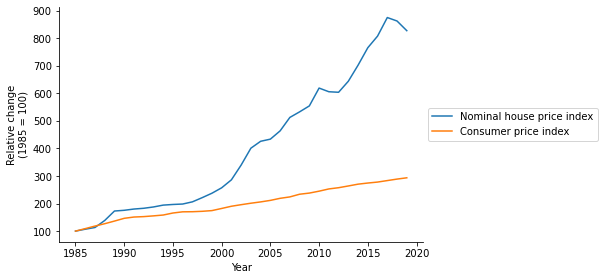

In [19]:
fig, ax = plt.subplots(figsize=(8.5,4), tight_layout=True)
ax.plot(df.index, df["RPPI"].to_numpy()/df["RPPI"].iloc[0]*100)
ax.plot(df.index, df["Inflation"].to_numpy()/df["Inflation"].iloc[0]*100)
ax.set_xlabel("Year")
ax.set_ylabel("Relative change\n(1985 = 100)")
ax.legend(["Nominal house price index","Consumer price index"], loc=6, bbox_to_anchor=(1,0.5))
sns.despine(fig=fig)

The data does support the claim that the house price has increased at a much faster rate than inflation.

Next, I will investigate the relationship between the house price and population

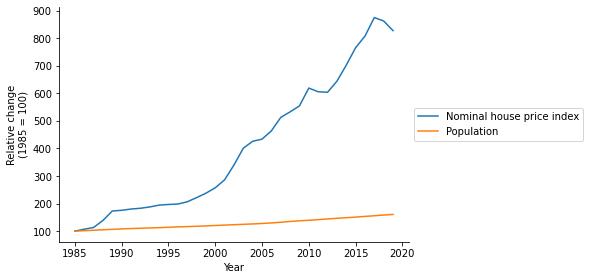

In [20]:
fig, ax = plt.subplots(figsize=(8.3,4), tight_layout=True)
ax.plot(df.index, df["RPPI"].to_numpy()/df["RPPI"].iloc[0]*100)
ax.plot(df.index, df["Population"].to_numpy()/df["Population"].iloc[0]*100)
ax.set_xlabel("Year")
ax.set_ylabel("Relative change\n(1985 = 100)")
ax.legend(["Nominal house price index","Population"], loc=6, bbox_to_anchor=(1,0.5))
sns.despine(fig=fig)

It is obvious that the house price has increased significantly faster than the Australian population. Between 1985-2019, the population has only almost doubled, but the house price has risen by 800%. This result seems to suggest that immigration is not the main factor in driving up the house price in Australia.

Let us now look at the explanation by The Economist, which suggests that a lack of new housing construction is to blame.

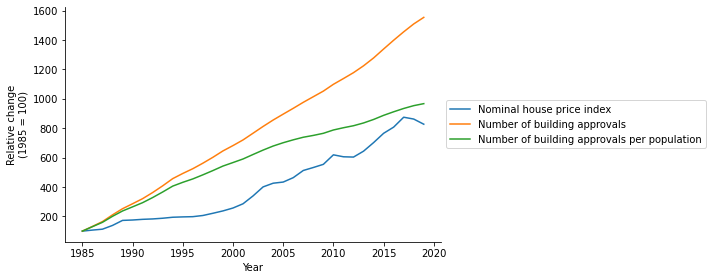

In [21]:
fig, ax = plt.subplots(figsize=(10,4), tight_layout=True)
ax.plot(df.index, df["RPPI"].to_numpy()/df["RPPI"].iloc[0]*100)
ax.plot(df.index, df["Building"].to_numpy()/df["Building"].iloc[0]*100)
ax.plot(df.index, (df["Building"]/df["Population"]).to_numpy()/(df["Building"].iloc[0]/df["Population"].iloc[0])*100)
ax.set_xlabel("Year")
ax.set_ylabel("Relative change\n(1985 = 100)")
ax.legend(["Nominal house price index","Number of building approvals","Number of building approvals per population"],
          loc=6, bbox_to_anchor=(1,0.5))
sns.despine(fig=fig)

The number of newly built houses has increased strongly over the years, even outpacing the rise in house prices. However, when I take into account the population number, the data does suggest that the number of new dwellings is not keeping up with the rise in population. Most notable, the number of new approvals per population started to slow down after 2000, which coincided with a sudden sharp rise in house price. By 2019, the house price index almost catches up to the number of new approvals per population. Therefore, the data does corroborate The Economist's claim that a lack of new housing construction is a major contributor to the housing crisis, at least in Australia.

Lastly, let us look at the effect of interest rate.

Text(0, 0.5, 'RBA Interest rate (%)')

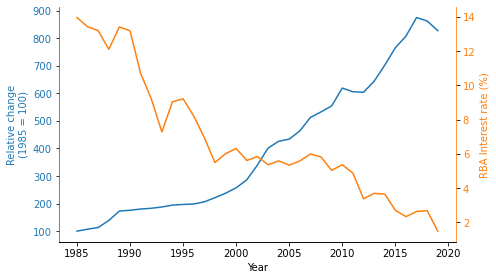

In [22]:
fig, ax1 = plt.subplots(figsize=(7,4), tight_layout=True)
c1, c2 = "tab:blue", "tab:orange"
ax1.plot(df.index, df["RPPI"].to_numpy()/df["RPPI"].iloc[0]*100, color=c1)
ax1.tick_params(axis='y', labelcolor=c1)
ax2 = ax1.twinx()
ax2.plot(df.index, df["Interest"].to_numpy(), color=c2)
ax1.spines['left'].set_color(c1)
ax2.spines['right'].set_color(c2)
ax2.tick_params(axis='y', labelcolor=c2)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.set_xlabel("Year")
ax1.set_ylabel("Relative change\n(1985 = 100)", color=c1)
ax2.set_ylabel("RBA Interest rate (%)", color=c2)

As expected, a lower interest rate makes residential housing investment more attractive. Interesting, the interest rate decreased significantly from 14% in 1985 to around 6% by 2000, but the house prices increased by a much slower rate during the same period. This suggests that, again, there are other factors contributing to the house price increase.

## Data analysis

First I want to see if the independent variables are correlated with one another.

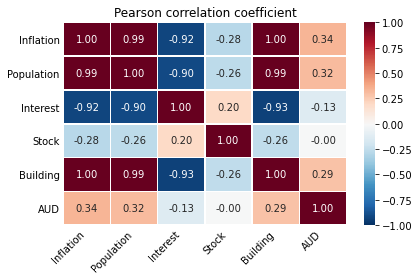

In [23]:
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
sns.heatmap(df.iloc[:,1:].corr(method="pearson"), cmap="RdBu_r", vmin=-1, vmax=1,
           annot=True, fmt=".2f", linewidth=0.5, ax=ax)
ax.set_title("Pearson correlation coefficient")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.tick_params(which='both', length=0)

The CPI, population and building approvals are well correlated with one another, because these 3 factors are guanranteed to increase with time. On the other hand, the interest rate has been steadily decreasing over the years, resulting in a high degree of anti-correlation with inflation, population and building approvals.

Now I will perform simple linear regression using each independent variable separately.

In [24]:
for i in df.columns[1:]:
    x = df[i].to_numpy().reshape(-1,1)
    x = sm.add_constant(x)
    model = sm.OLS(df["RPPI"].to_numpy().reshape(-1,1), x)
    model_fit = model.fit()
    print(f"{i} R-squared = {model_fit.rsquared:.2f}, coefficient = {model_fit.params[1]:.3g}")

Inflation R-squared = 0.95, coefficient = 1.55
Population R-squared = 0.98, coefficient = 0.0113
Interest R-squared = 0.72, coefficient = -7.69
Stock R-squared = 0.06, coefficient = -0.461
Building R-squared = 0.96, coefficient = 1.87e-05
AUD R-squared = 0.13, coefficient = 94.2


Each of inflation, population and building approvals can explain at least 95% of the variance in the house price. This is most likely because these 4 values almost always increase with time. Together with the strong multicollinearity of some independent variables, I conclude that the data I am using at the moment is not suitable for modeling the change in house price with multiple linear regression.

As a result, I will model the annual rate of change in house prices, and use the annual rate of change in CPI (ie, inflation rate), population, building approvals and the AUD value instead.

In [25]:
# Make a new data frame
df2 = df.iloc[1:,:].copy()
for i in ["RPPI","Inflation","Population","Building","AUD"]:
    df2[i] = np.diff(df[i].to_numpy())/df[i].iloc[:-1].to_numpy()*100
df2.head()

,RPPI,Inflation,Population,Interest,Stock,Building,AUD
1986,6.953543,9.050355,1.498057,13.41667,48.693359,31.945688,-2.364518
1987,5.788580,8.533020,1.585000,13.19167,-16.231732,24.912253,8.679302
1988,22.531442,7.215929,1.784124,12.10417,3.108223,27.769797,18.408304
1989,24.732474,7.533897,1.495766,13.40833,5.220613,19.918023,-7.340736
1990,1.531997,7.333025,1.376301,13.18000,-5.970834,13.373140,-2.447332


Let us look at the rate of change in house price and population.

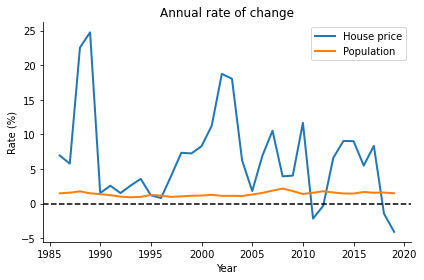

In [26]:
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.plot(df2.index.to_numpy(), df2["RPPI"].to_numpy(), lw=2)
ax.plot(df2.index.to_numpy(), df2["Population"].to_numpy(), lw=2)
ax.axhline(y=0, ls='--', c='k')
ax.set_xlabel("Year")
ax.set_ylabel("Rate (%)")
ax.legend(["House price","Population"])
ax.set_title("Annual rate of change")
sns.despine(fig=fig)

The annual Australian population has always increased, whereas the house price index only fell in three years (around 2011, and after 2018).

Now I will recalculate the correlation between the independent variables.

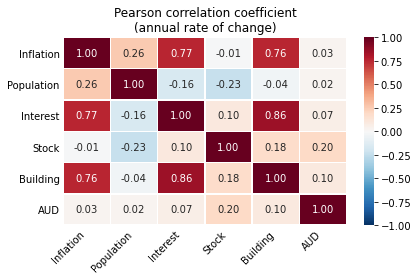

In [27]:
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
sns.heatmap(df2.iloc[:,1:].corr(method="pearson"), cmap="RdBu_r", vmin=-1, vmax=1,
           annot=True, fmt=".2f", linewidth=0.5, ax=ax)
ax.set_title("Pearson correlation coefficient\n(annual rate of change)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.tick_params(which='both', length=0)

The correlation between some independent variables have significantly been reduced. I also observe that inflation is positively correlated with the interest rate. This is interesting, because a higher interest rate is supposed to result in reduced inflation. The observed positive correlation instead points to the environment of low interest rate and low inflation, a situation that is most pronounced in Japan.

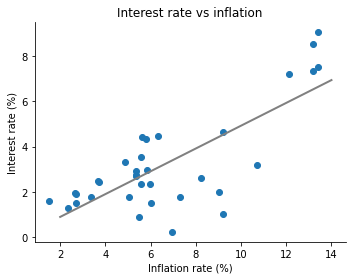

In [28]:
fig, ax = plt.subplots(figsize=(5,4), tight_layout=True)
ax.scatter(df2["Interest"].to_numpy(), df2["Inflation"].to_numpy())
a, b = np.polyfit(df2["Interest"].to_numpy(), df2["Inflation"].to_numpy(), 1)
ax.plot([2,14], a*np.array([2,14])+b, lw=2, c='grey')
ax.set_xlabel("Inflation rate (%)")
ax.set_ylabel("Interest rate (%)")
ax.set_title("Interest rate vs inflation")
sns.despine(fig=fig)

The increase in building approvals is also positively correlated with the interest rate and inflation rate. I did not expect this, because a higher interest rate should lead to higher borrowing cost, and a higher inflation rate should increase material cost, both of which lead to higher cost of housing construction. However, a look at the change of building approval rate over time suggests that it has been steadily decreasing, just like how the interest rate and inflation have been, over the year. I suspect that there is actually no causal relationship between interest rate/inflation rate and the building rate, but rather Australia has been building more or less the same number of new houses over the period, as can be observed by the linear trend in the plot of the cumulative number of building approvals above.

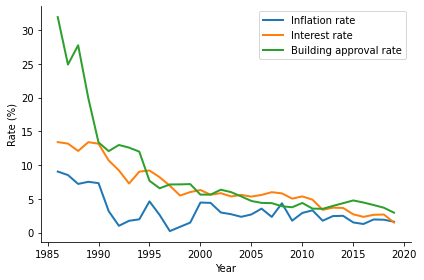

In [29]:
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.plot(df2.index.to_numpy(), df2["Inflation"].to_numpy(), lw=2)
ax.plot(df2.index.to_numpy(), df2["Interest"].to_numpy(), lw=2)
ax.plot(df2.index.to_numpy(), df2["Building"].to_numpy(), lw=2)
ax.set_xlabel("Year")
ax.set_ylabel("Rate (%)")
ax.legend(["Inflation rate","Interest rate","Building approval rate"], loc=0)
sns.despine(fig=fig)

Now I will perform simple linear regression using each independent variable separately.

In [30]:
# Linear regression
for i in df2.columns[1:]:
    x = df2[i].to_numpy().reshape(-1,1)
    x = sm.add_constant(x)
    model = sm.OLS(df2["RPPI"].to_numpy().reshape(-1,1), x)
    model_fit = model.fit()
    print(f"{i} R-squared = {model_fit.rsquared:.2f}, coefficient = {model_fit.params[1]:.3g}")

Inflation R-squared = 0.12, coefficient = 1.02
Population R-squared = 0.00, coefficient = 0.547
Interest R-squared = 0.06, coefficient = 0.493
Stock R-squared = 0.00, coefficient = -0.0063
Building R-squared = 0.11, coefficient = 0.298
AUD R-squared = 0.09, coefficient = 0.162


It is clear that each variable by itself cannot adequately explain the rate of change in house price. The best single predictor is the inflation rate, which can explain 12% of the variance in the increase in house price. Furthermore, the model suggests that an increase in inflation rate by 1 percentage point will correspond to a 1-percentage point increase in house price change. This is expected, because the total CPI takes into account the house prices, and because house price should at least keep up with inflation.

Now I will perform multiple linear regression, assuming that the intercept is 0 because I expect that when all the independent variables are 0, the house prices should not change.

In [31]:
model = sm.OLS(df2["RPPI"].to_numpy().reshape(-1,1), df2.iloc[:,1:].to_numpy())
model_fit = model.fit()
print(model_fit.summary())
print(f"***** Coefficient meanings: {df2.columns[1:].to_list()}")

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.603
Model:                            OLS   Adj. R-squared (uncentered):              0.518
Method:                 Least Squares   F-statistic:                              7.090
Date:                Wed, 03 Feb 2021   Prob (F-statistic):                    0.000115
Time:                        12:58:53   Log-Likelihood:                         -108.29
No. Observations:                  34   AIC:                                      228.6
Df Residuals:                      28   BIC:                                      237.7
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

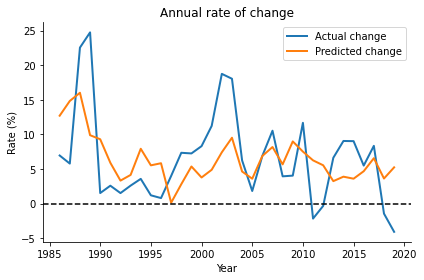

In [32]:
# Actual vs predicted change in house price
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.plot(df2.index.to_numpy(), df2["RPPI"].to_numpy(), lw=2)
ax.plot(df2.index.to_numpy(), model_fit.predict(), lw=2)
ax.axhline(y=0, ls='--', c='k')
ax.set_xlabel("Year")
ax.set_ylabel("Rate (%)")
ax.legend(["Actual change","Predicted change"])
ax.set_title("Annual rate of change")
sns.despine(fig=fig)

Using all 6 variables, I was able to explain 60% of the variance in house price increase. The house price increase is positively correlated with inflation, population, building approvals and the AUD's strength. On ther hand, the house price increase is negatively correlated with interest rate and stock market performance.

## Conclusion

The model suggests that the population has the strongest effect on house price: a 1-percentage point increase in population changes leads to a 2.2-percentage point increase in house price changes. This finding disagrees with the Sydney Morning Herald report, probably because the report did not include other variables, and because people who invest in residential properties are not concerned about the COVID-19 pandemic, which is a short-term event in the eye of an investor. Moreover, the lower interest rate during the pandemic could have compensated for the loss of immigration.

Contrary to the Economist's special report, a rise in building approval actually leads to a rise in house price. This could be because the decision to build new dwellings is reactionary to the house price: if the house price is increasing, investors want to build more houses with the hope that house prices will keep increasing. Furthermore, the rise in housing construction could lag behind the expected fall in house price, because there is a delay between obtaining the building approvals to the houses being available for purchase.

The stock market return has the weakest effect on the house price, suggesting that investors would always find residential properties attractive, regardless of the stock market performance.

I also find it interesting that the house price is positively correlated to the strength of the Australian dollar. This is probably because as the Australian dollar becomes stronger, Australia imports would grow, thus stimulating the Australian economy and its consummers, which in turn leads to higher house prices.

Based on this model, if policy makers want to slow down the rise in house prices in Australia, the most reasonable proposal is to raise the interest rate, but the effect would be small: a 1 percentage point increase to interest rate only leads to a 0.06 percentage point decrease in house price's rate of change. Another potential policy change is to reduce the Australian population growth, most likely through limiting immigration. However, this might have negative consequences to the Australian economy in the future, because the Australian population is ageing.

## Limititations and future directions

In the multiple linear regression model, none of the coefficients are statistically significant (all P-values are higher than 0.05), suggesting that the sample size is not sufficient with regards to the variance of the variables. Furthermore, the analysis only shows correlation, not causation, of the house prices. There are also other factors that I have not considered, such as rental cost (a high price-to-rent ratio could indicate that investors are buying houses for capital gain, rather than rental income), government tax scheme (Australia allows negative gearing and generous capital gain tax rules, promoting property investment for capital gain), and most importantly the fact that the housing market in each state and each capital city is different.

In a future study, one could analyze the house price state by state, capital city by capital city, and quarter by quarter (instead of year by year in this analysis) to capture the region-specific effects and potentially improve the model's accuracy. I would also propose analyzing the building approvals for public and private sector separately, because I think that private sector construction is reactionary to house prices, whereas the public sector construction could be a genuine source of housing supply. Lastly, after 2010, there was a concern among Australians that overseas investors were willing to pay much more than the asking price for properties in Australia, thus driving up the house prices. It would be interesting to incorporate the data about overseas investment in residential housing directly into the model, instead of just using the strength of the Australian dollar.

## Sources
1. https://www.abc.net.au/news/2020-11-06/property-bubble-burst-coronavirus-pandemic-house-prices/12852854
2. https://www.aph.gov.au/about_parliament/parliamentary_departments/parliamentary_library/pubs/briefingbook45p/housingaffordability
3. https://www.abs.gov.au/statistics/people/population/migration-australia/latest-release#:~:text=In%202019%2C%20there%20were%20over,in%20Australia's%20population%20in%202019
4. https://www.smh.com.au/business/the-economy/why-are-australian-home-prices-rising-again-and-can-it-last-20210126-p56wte.html
5. https://www.economist.com/special-report/2020/01/16/housing-is-at-the-root-of-many-of-the-rich-worlds-problems
6. https://stats.oecd.org/
7. https://www.abs.gov.au/statistics/industry/building-and-construction/building-approvals-australia/latest-release
8. https://www.rba.gov.au/statistics/historical-data.html#exchange-rates
9. https://www.abs.gov.au/statistics/people/population/national-state-and-territory-population/jun-2020